# Information geometry

Lead author: Alice Le Brigant.

Disclaimer: this notebook requires the use of the ```numpy``` backend.

## Table of contents:
* [Introduction](#sec1)
* [Geometry of normal distributions](#sec2)
* [Geometry of beta distributions](#sec3)
* [Learning on spaces of distributions](#sec4)
    - [Fréchet mean of beta distributions](#sec4.1)
    - [K-Means clustering of normal distributions](#sec4.2)
    - [Principal Geodesic Analysis of normal distributions](#sec4.3)

## Introduction <a class="anchor" id="sec1"></a>

Information geometry is a branch of mathematics at the crossroads of statistics and differential geometry, focused on the study of probability distributions from a geometric point of view. One of the tools of information geometry is the Fisher-Rao information distance, which allows to compare probability distributions inside a given parametric family. In that sense, information geometry is an alternative approach to optimal transport. 

The Fisher-Rao metric is a Riemannian metric defined on the space of parameters of a family of distributions using the Fisher information matrix. This metric is invariant under change of parameterization. Moreover it is the only Riemannian metric compatible with the notion of information contained by the model on the parameter, in the sense that it is the only metric that preserves the geometry of a parametric model after transformation by a sufficient statistic (Cencov's theorem). For an overview, see [[A2016]](#References).

In [1]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import geomstats.backend as gs
import geomstats.visualization as visualization

INFO: Using numpy backend


## Geometry of normal distributions <a class="anchor" id="sec2"></a>

The Fisher information geometry of the family of normal distributions is arguably the most well-known. The space of parameters is the upper half-plane where the x-coordinate encodes the mean and the y-coordinate the standard deviation. Quite remarkably, the Fisher information metric induces the hyperbolic geometry of the Poincare half plane [[AM1981]](#References). To start, we need an instance of the class ```NormalDistributions``` and its Fisher information metric.

In [2]:
from geomstats.information_geometry.normal import NormalDistributions

normal = NormalDistributions(sample_dim=1)

Using the ```visualization``` module, we can plot the geodesic between two points, each defining the parameters (mean and standard deviation) for a normal distribution. We recognise the shape of a geodesic of the Poincare half-plane, namely a half-circle orthogonal to the x-axis.

In [3]:
point_a = gs.array([1.0, 1.0])
point_b = gs.array([3.0, 1.0])

geodesic_ab_fisher = normal.metric.geodesic(point_a, point_b)

n_points = 20
t = gs.linspace(0, 1, n_points)

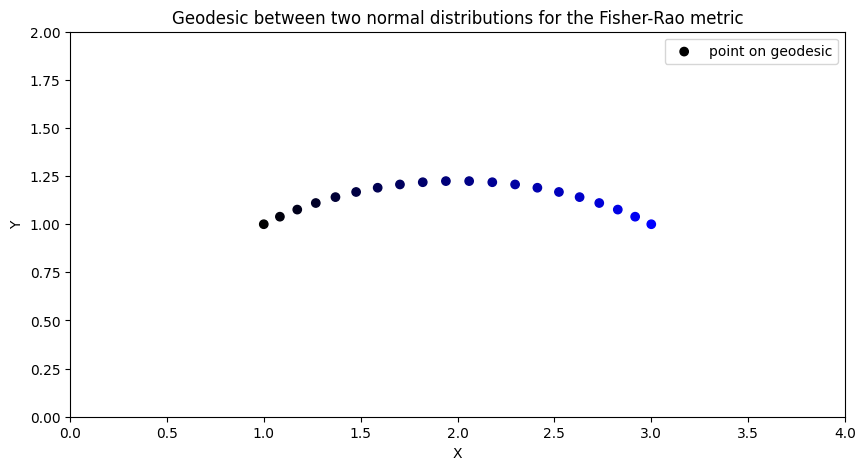

In [4]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
cc = gs.zeros((n_points, 3))
cc[:, 2] = gs.linspace(0, 1, n_points)

visualization.plot(
    geodesic_ab_fisher(t),
    ax=ax,
    space="H2_poincare_half_plane",
    label="point on geodesic",
    color=cc,
)

ax.set_xlim(0.0, 4.0)
ax.set_ylim(0.0, 2.0)
ax.set_title("Geodesic between two normal distributions for the Fisher-Rao metric")
ax.legend();

Each point of the geodesic defines a normal distribution, and so we obtain an optimal interpolation between the distributions corresponding to ```point_a``` and ```point_b```, which we can visualize in terms of probability density functions.

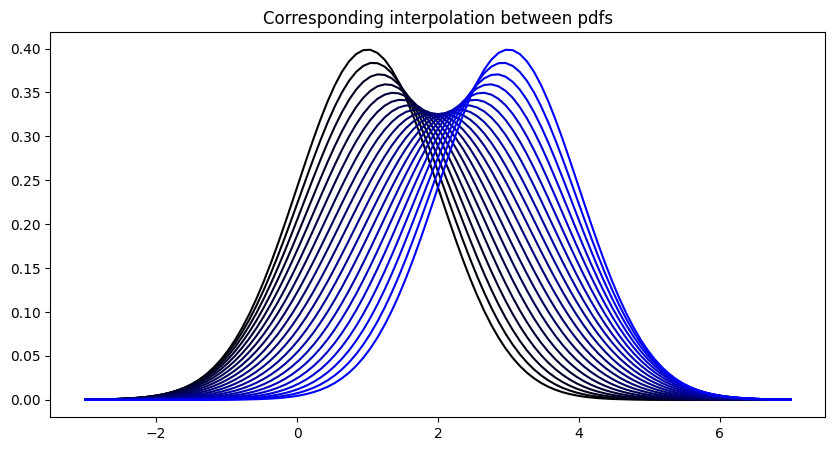

In [5]:
pdfs = normal.point_to_pdf(geodesic_ab_fisher(t))
x = gs.linspace(-3.0, 7.0, 100)

fig = plt.figure(figsize=(10, 5))
for i in range(n_points):
    plt.plot(x, pdfs(x)[i, :], color=cc[i, :])
plt.title("Corresponding interpolation between pdfs");

Another possibility to compare probability distributions is given by the $L^2$-Wasserstein metric, central in optimal transport. In the case of normal distributions, the $L^2$-Wasserstein metric induces the Euclidean geometry on the parameter space [[BGKL2017]](#References). Therefore, the Wasserstein distance between two normal distributions with different means and same variance (```point_a``` and ```point_b```) will not change when this common variance is increased (```point_c``` and ```point_d```), while the corresponding Fisher information distance will decrease, as can be deduced from the shape of the geodesic. This can be interpreted as a consequence of the increasing overlap of the corresponding probability densities, as noticed in [[CSS2015]](#References).

In [6]:
from geomstats.geometry.euclidean import Euclidean

plane = Euclidean(2)

point_c = gs.array([1.0, 3.0])
point_d = gs.array([3.0, 3.0])

geodesic_cd_fisher = normal.metric.geodesic(point_c, point_d)
geodesic_ab_wasserstein = plane.metric.geodesic(point_a, point_b)
geodesic_cd_wasserstein = plane.metric.geodesic(point_c, point_d)

points = gs.stack((point_a, point_b, point_c, point_d))
pdfs = normal.point_to_pdf(points)

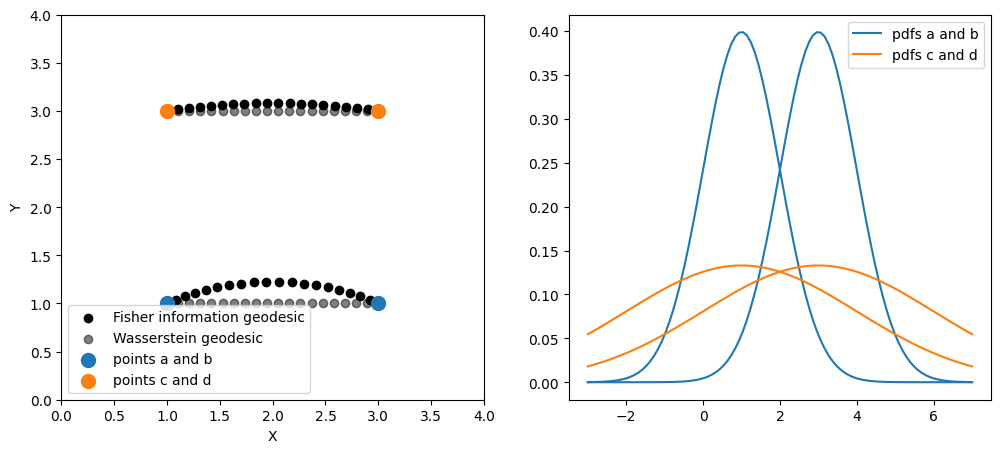

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)

visualization.plot(
    gs.vstack((geodesic_ab_fisher(t), geodesic_cd_fisher(t))),
    ax=ax1,
    space="H2_poincare_half_plane",
    label="Fisher information geodesic",
    color="black",
)
visualization.plot(
    gs.vstack((geodesic_ab_wasserstein(t), geodesic_cd_wasserstein(t))),
    ax=ax1,
    space="H2_poincare_half_plane",
    label="Wasserstein geodesic",
    color="black",
    alpha=0.5,
)
visualization.plot(
    gs.stack((point_a, point_b)),
    ax=ax1,
    space="H2_poincare_half_plane",
    label="points a and b",
    s=100,
)
visualization.plot(
    gs.stack((point_c, point_d)),
    ax=ax1,
    space="H2_poincare_half_plane",
    label="points c and d",
    s=100,
)

ax1.set_xlim(0.0, 4.0)
ax1.set_ylim(0.0, 4.0)
ax1.legend()

ax2 = fig.add_subplot(122)
x = gs.linspace(-3.0, 7.0, 100)
lines = [Line2D([0], [0], color="C0"), Line2D([0], [0], color="C1")]
ax2.plot(x, pdfs(x)[:2, :].T, c="C0")
ax2.plot(x, pdfs(x)[2:, :].T, c="C1")
ax2.legend(lines, ["pdfs a and b", "pdfs c and d"]);

## Geometry of beta distributions <a class="anchor" id="sec3"></a>

Let us now consider the example of beta distributions, where the space of parameters is the first quadrant. In this case, the geodesics for the Fisher-Rao metric do not have a closed form, but can be found numerically [[LGRP2020]](#References). Here we plot an example of geodesic ball.

In [8]:
from geomstats.information_geometry.beta import BetaDistributions

beta = BetaDistributions()

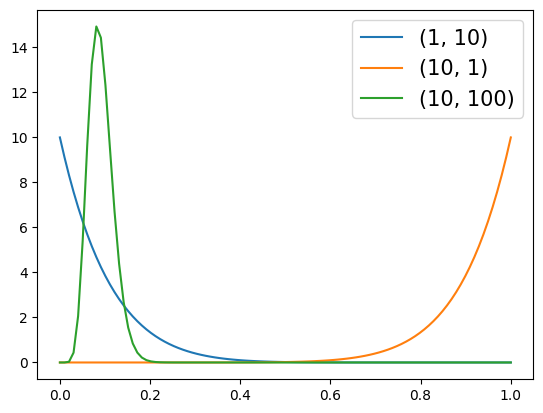

In [9]:
point_a = gs.array([1., 10.])
point_b = gs.array([10., 1.])
point_c = gs.array([10., 100.])

samples = gs.linspace(0., 1., 100)
points = gs.stack([point_a, point_b, point_c])
pdfs = beta.point_to_pdf(points)(samples)
plt.plot(samples, pdfs.T)
plt.legend(['(1, 10)', '(10, 1)', '(10, 100)'], prop={'size':15})
plt.show()

In [10]:
print('Fisher-Rao distance between blue and yellow: ', beta.metric.dist(point_a, point_b))
print('Fisher-Rao distance between blue and green: ', beta.metric.dist(point_a, point_c))

Fisher-Rao distance between blue and yellow:  4.230720208803747
Fisher-Rao distance between blue and green:  1.7253568493169043


In [11]:
r2 = Euclidean(2)
print('Euclidean distance between blue and yellow: ', r2.metric.dist(point_a, point_b))
print('Euclidean distance between blue and green: ', r2.metric.dist(point_a, point_c))

Euclidean distance between blue and yellow:  12.727922061357855
Euclidean distance between blue and green:  90.44888059008801


We can see that for the Euclidean distance on the parameter space, the blue pdf is closer to the yellow pdf than to the green one, while the converse is true for the Fisher-Rao metric. The Fisher-Rao values seem more natural considering the mass overlap between these pdfs. More generally, the Fisher-Rao metric gives smallest cost to the displacements in the directions that preserve the mean, as we can see on the plot bellow, representing a geodesic ball centered at the red point, i.e. all points that are at same distance from that point. We can see that this ball is "stretched" in the direction of the line of equation "x=y", which corresponds to all the distributions with same mean as the one defined by the center of the ball.

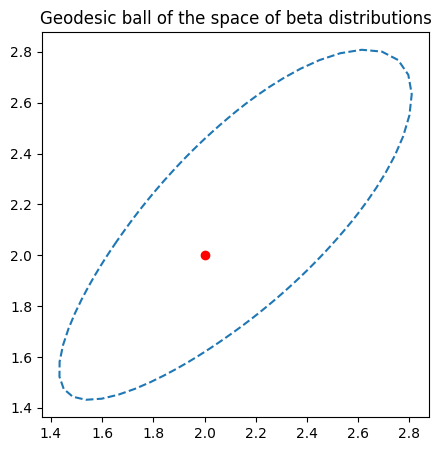

In [12]:
n_rays = 100
center = gs.array([2.0, 2.0])

theta = gs.linspace(-gs.pi, gs.pi, n_rays)
directions = gs.transpose(gs.stack((gs.cos(theta), gs.sin(theta))))
ray_length = .25
direction_norms = beta.metric.norm(directions, center)
unit_vectors = directions / gs.expand_dims(direction_norms, 1)
initial_vectors = ray_length * unit_vectors

ball = beta.metric.exp(initial_vectors, center)

plt.figure(figsize=(5, 5))
plt.plot(ball[:, 0], ball[:, 1], '--')
plt.plot(*center, 'or')
plt.title("Geodesic ball of the space of beta distributions");

## Learning on spaces of distributions <a class="anchor" id="sec4"></a>

### Fréchet mean of beta distributions <a class="anchor" id="sec4.1"></a>

Now we consider an application to the study of the leaf inclination angle distribution of plants. The leaf angle distribution among a common plant species can be appropriately represented by a beta distribution ([CPR2018](#References)). The dataset `leaves` ([CPR2018](#References)) contains pairs of beta distribution parameters, each describing the distribution of the inclination angles of leaves inside a given plant species. These species are divided into 5 categories according to inclination angle distribution type: spherical, erectophile, uniform, planophile and plagiophile.

In [13]:
import geomstats.datasets.utils as data_utils

beta_param, distrib_type = data_utils.load_leaves()

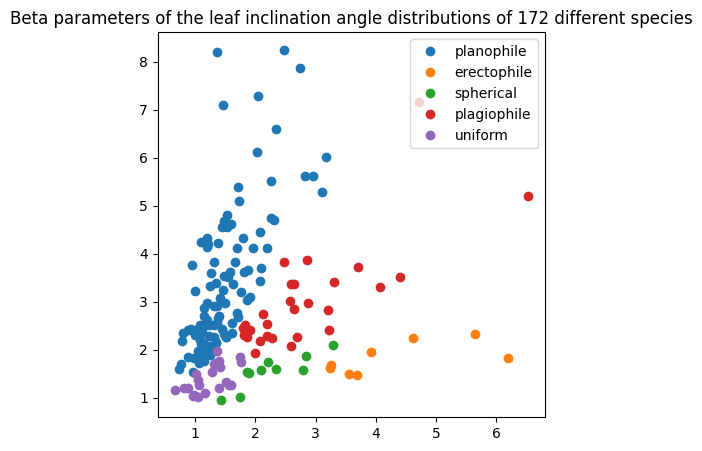

In [14]:
fig = plt.figure(figsize=(5, 5))
for distrib in set(distrib_type):
    points = beta_param[distrib_type == distrib, :]
    plt.plot(points[:, 0], points[:, 1], "o", label=distrib)
plt.title(
    "Beta parameters of the leaf inclination angle distributions of 172 different species"
)
plt.legend();

Using the ```FrechetMean``` learning class, we can compute the leaf inclination angle mean distribution among the species of type 'planophile'.

In [15]:
from geomstats.learning.frechet_mean import FrechetMean

points_plan = beta_param[distrib_type == "planophile", :]

mean = FrechetMean(beta)
mean.fit(points_plan)

mean_estimate = mean.estimate_

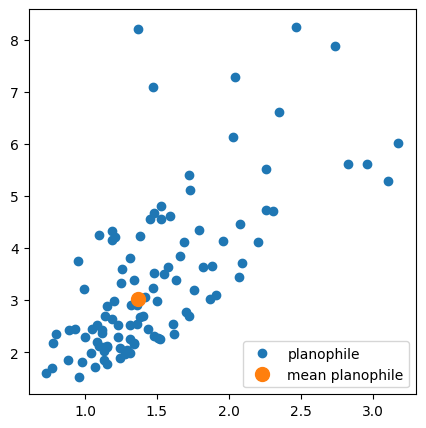

In [16]:
fig = plt.figure(figsize=(5, 5))
plt.plot(points_plan[:, 0], points_plan[:, 1], "o", label="planophile")
plt.plot(*mean_estimate, "o", markersize=10, label="mean planophile")
plt.legend();

### K-Means clustering of normal distributions <a class="anchor" id="sec4.2"></a>

We now show how this geometry can be used to perform K-means clustering of probability distributions. We consider a toy dataset of normal distributions.

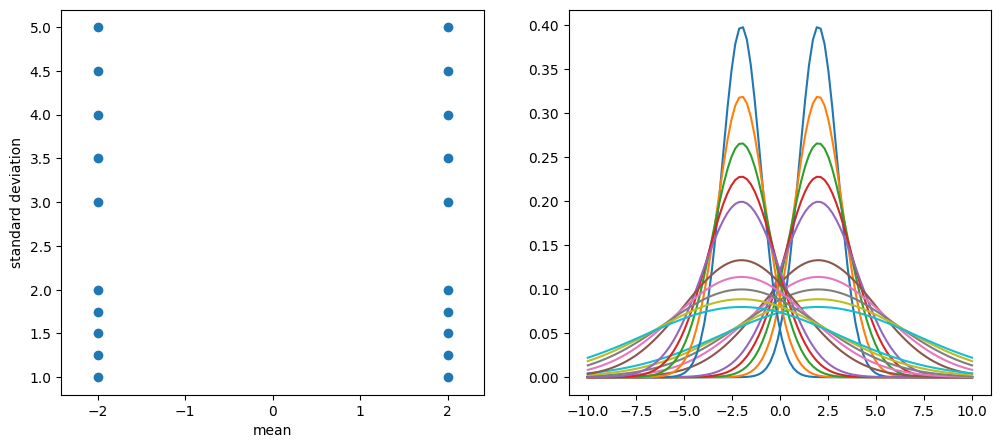

In [17]:
n = 10
x_a = 2 * gs.ones(n)
x_b = -2 * gs.ones(n)
y_a = y_b = gs.hstack((gs.linspace(1., 2., 5), gs.linspace(3., 5., 5)))
points_a = gs.stack((x_a, y_a)).T
points_b = gs.stack((x_b, y_b)).T
points = gs.vstack((points_a, points_b))

n_samples = 100
samples = gs.linspace(-10., 10., n_samples)
pdfs = normal.point_to_pdf(points)(samples)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax1.plot(points[:, 0], points[:, 1], 'o')
ax1.set_xlabel('mean')
ax1.set_ylabel('standard deviation')
ax1.axis('equal')
ax2 = fig.add_subplot(122)
ax2.plot(samples, pdfs.T)
plt.show()

In [18]:
def plot_clusters(points, labels, samples, colors=['r', 'b', 'g']):
    cluster = []
    pdf = []
    n_clusters = len(set(labels))
    for i in range(n_clusters):
        cluster.append(points[labels == i])
        pdf_fun = normal.point_to_pdf(cluster[-1])
        pdf.append(pdf_fun(samples))

    fig = plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for i in range(n_clusters):
        plt.scatter(cluster[i][:, 0], cluster[i][:, 1], color=colors[i])
    plt.xlabel('mean')
    plt.ylabel('standard deviation')
    plt.axis('equal')
    plt.title('Parameters of clusters')
    
    plt.subplot(1, 2, 2)
    for i in range(n_clusters):
        plt.plot(samples, pdf[i].T, color=colors[i])
    plt.title('Pdfs of clusters')
    plt.show()

We perform K-means clustering using the Fisher-Rao metric, and then the Euclidean metric in the parameter space, looking for 3 different clusters.

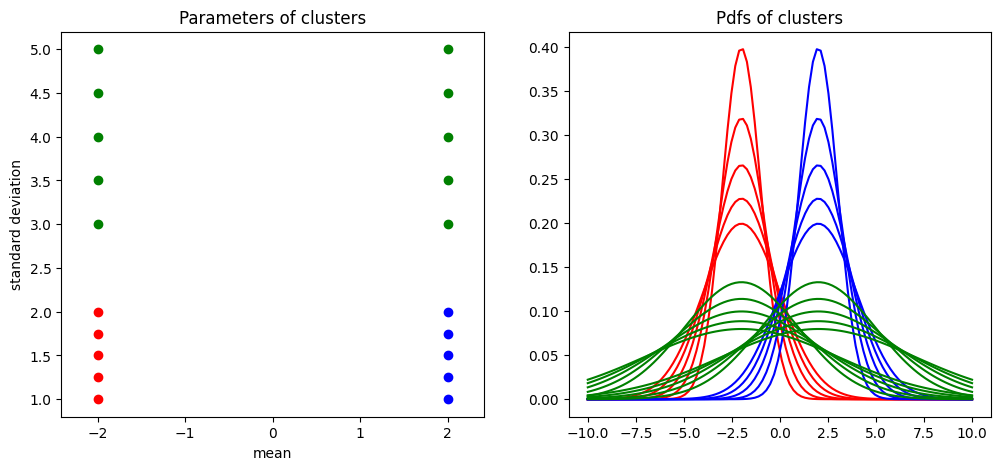

In [19]:
from geomstats.learning.kmeans import RiemannianKMeans

clustering = RiemannianKMeans(space=normal, n_clusters=3, init="kmeans++")
clustering.fit(points)

plot_clusters(points, clustering.labels_, samples)

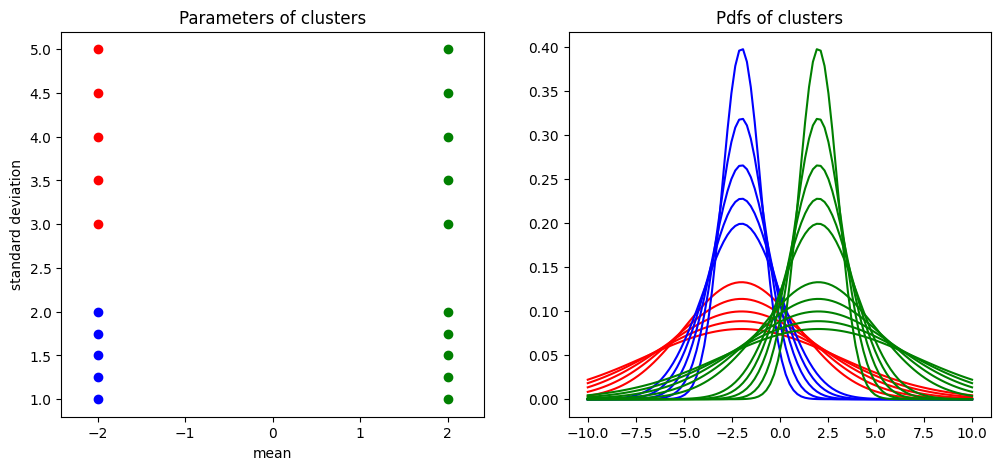

In [20]:
clustering = RiemannianKMeans(space=r2, n_clusters=3, init="kmeans++")
clustering.fit(points)

plot_clusters(points, clustering.labels_, samples)

We see that the Fisher-Rao metric will group the distributions with high variance together, because they have high mass overlap, while the Euclidean metric (which corresponds to the Wasserstein metric in the Gaussian case) does not take this difference into account.

### Principal geodesic analysis of normal distributions <a class="anchor" id="sec4.3"></a>

Principal Component Analysis is a procedure that allows to find directions of maximal variance inside a dataset in a Euclidean space. It can be extended to Riemannian manifolds, in which case it is called Principal Geodesic Analysis (PGA). In Riemannian manifolds, we look for geodesics along which the projected data have maximal variance. In general, performing exact PGA in a curved space is difficult, and a linearized version (tangent PCA) is often used. However, in the Fisher-Rao geometry of univariate normal distributions things are particularly simple due to the constant curvature. Here we use the formulas of [[CSV2016]](#References).

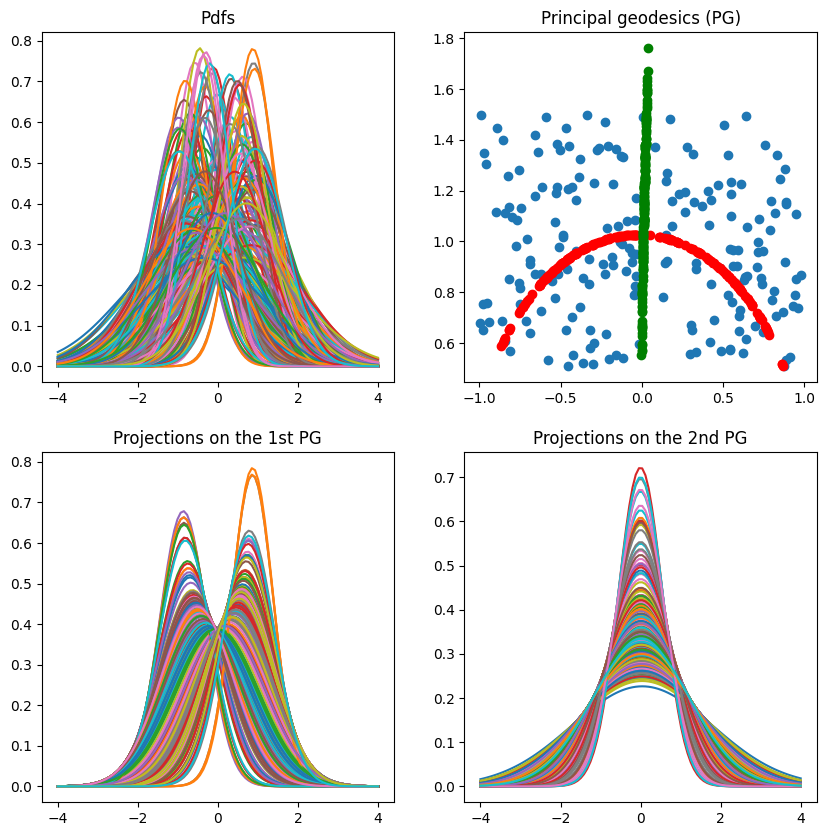

In [28]:
from geomstats.learning.pca import HyperbolicPlanePCA

n_points = 200

means = -1. + 2. * gs.random.rand(n_points)
stds = 0.5 + gs.random.rand(n_points)
points = gs.transpose(gs.stack((means, stds)))

samples = gs.linspace(-4., 4., 100)
pdfs = normal.point_to_pdf(points)(samples)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax1.plot(samples, pdfs.T)
ax1.set_title('Pdfs')

pca = HyperbolicPlanePCA(normal)
proj_points = pca.fit_transform(points)

ax2 = fig.add_subplot(222)
ax2.plot(points[:, 0], points[:, 1], 'o')
ax2.plot(proj_points[0, :, 0], proj_points[0, :, 1], 'or')
ax2.plot(proj_points[1, :, 0], proj_points[1, :, 1], 'og')
ax2.set_title('Principal geodesics (PG)')

proj_pdfs_1 = normal.point_to_pdf(proj_points[0])(samples)
proj_pdfs_2 = normal.point_to_pdf(proj_points[1])(samples)

ax3 = fig.add_subplot(223)
ax3.plot(samples, proj_pdfs_1.T)
ax3.set_title('Projections on the 1st PG')

ax4 = fig.add_subplot(224)
ax4.plot(samples, proj_pdfs_2.T)
ax4.set_title('Projections on the 2nd PG')
plt.show()

We see that the first principal component has captured the variation in mean while the second component the variation in variance. 

## References

.. [A2016] S. Amari. Information geometry and its applications. Vol. 194. Springer, 2016.

.. [AM1981] C. Atkinson and A. FS Mitchell. Rao’s distance measure. Sankhya: The Indian Journal of Statistics. Series A, pp. 345–365, 1981.

.. [BGKL2017] J. Bigot, R. Gouet, T. Klein and A. López. Geodesic PCA in the Wasserstein space by convex PCA. In Annales de l'Institut Henri Poincaré, Probabilités et Statistiques. Vol. 53. No. 1. Institut Henri Poincaré, 2017.

.. [CSV2016] R. Chakraborty, D. Seo and B. Vemuri. An efficient exact-pga algorithm for constant curvature manifolds. Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

.. [CPR2018] F. Chianucci, J. Pisek, K. Raabe et al. A dataset of leaf inclination angles for temperate and boreal broadleaf woody species. Annals of Forest Science Vol. 75, No. 50, 2018. https://doi.org/10.17632/4rmc7r8zvy.2.

.. [CSS2015] S. Costa, S. Santos and J. Strapasson. Fisher information distance: a geometrical reading. Discrete Applied Mathematics. Vol. 197, 59-69, 2015.

.. [LGRP2020] A. Le Brigant, N. Guigui, S. Rebbah and S. Puechmorel, Classifying histograms of medical data using information geometry of beta distributions. IFAC-PapersOnLine, Vol. 54, No. 9, 514-520, 2021.